In [16]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab.envs.green_crab_movingAvg import greenCrabMonthNormalizedMoving
from rl4greencrab import evaluate_agent, multiConstAction, simulator, environment_simulation, plot_selected_sizes
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from huggingface_hub import hf_hub_download
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC, RecurrentPPO
from LipschitzPPO import LipschitzPPO
from LipschitzRecurrentPPO import LipschitzRecurrentPPO
import os
import plotnine
from plotnine import ggplot, geom_point, aes, geom_line, facet_wrap, geom_path

In [2]:
# Interpolate policy

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

#@ray.remote
def GaussianProcessPolicy(policy_df, length_scale=10, noise_level=0.1):
  """
  policy_df.columns = [X, Y, Z, act_x, act_y]
                    -> action (act_x, act_y) taken at point (X, Y, Z)
  """
  predictors = policy_df[["obs0", "obs1"]].to_numpy()
  targets = policy_df[["act0", "act1", 'act2']].to_numpy()
  kernel = (
    1.0 * RBF(length_scale = length_scale) 
    + WhiteKernel(noise_level=noise_level)
    )
  print("Fitting Gaussian Process...")
  gpp = (
    GaussianProcessRegressor(kernel=kernel, random_state=0)
    .fit(predictors, targets)
    )
  print("Done fitting Gaussian Process...")
  return gpp

In [3]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    # "curriculum": True
}
env = greenCrabMonthNormalizedMoving(config)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64


In [23]:
ppoAgent = PPO.load(f"PPO_gcmemoving", device="cpu")
ppoData = simulator(env = env, agent = ppoAgent).simulate_full_named_dict_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.000000,-1.000000,-1.000000,-0.966465,-1.0,0.000000,0
1,1,-0.333068,4.938480,-1.000000,0.941904,-1.0,-0.001409,0
2,2,-0.666257,4.804779,-1.000000,0.117724,-1.0,-0.079149,0
3,3,-0.999495,4.754417,-1.000000,-1.000000,-1.0,-0.123921,0
4,4,-0.999760,-0.517396,-1.000000,-1.000000,-1.0,-0.123984,0
...,...,...,...,...,...,...,...,...
995,95,-0.996880,-0.549532,-0.303100,-1.000000,-1.0,-3.238589,9
996,96,-0.950945,-0.780906,1.000000,-1.000000,-1.0,-3.530498,9
997,97,-0.905887,-0.685976,0.465424,-1.000000,-1.0,-3.799195,9
998,98,-0.876968,-0.552020,-1.000000,-0.701961,-1.0,-3.917484,9


In [24]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])

<Axes: xlabel='t'>

In [5]:
recurrentPPOAgent = RecurrentPPO.load("RecurrentPPO_gcmenorm_256_1_{'pi': [256, 256], 'vf': [256, 256]}_False", device="cpu")
ppoData = simulator(env = env, agent = recurrentPPOAgent).simulate_full_named_dict_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)

In [6]:
df = ppoDataDF.drop(columns=['t', 'rew', 'rep'])

In [7]:
gpp = GaussianProcessPolicy(df)

Fitting Gaussian Process...
Done fitting Gaussian Process...


In [8]:
def generate_gpp_episodes(gpp, env, reps=50):
  """ gpp is a gaussian process regression of the RL policy """
  df_list = []
  for rep in range(reps):
    episode_reward = 0
    observation, _ = env.reset()
    population = env.observations['crabs']
    for t in range(env.Tmax):
      action = gpp.predict([population])[0]
      #print(f"pop = {population}")
      #print(f"action = {action}")
      esc_x = population[0] * (1 - action[0])
      esc_y = population[1] * (1 - action[1])
      
      df_list.append(np.append([t, rep, action[0], action[1], action[2], episode_reward, esc_x, esc_y], population))
      
      observation, reward, terminated, done, info = env.step(action)
      population = env.observations['crabs']
      
      episode_reward += reward
      if terminated:
        break
  cols =['t','rep', 'act0', 'act1', 'act2', 'rew', 'esc_x', 'esc_y' ,'obs0', 'obs1']
  df = pd.DataFrame(df_list, columns = cols)
  return df

In [9]:
DATAPATH = '.'
ITERATIONS = 1000
print("Finished fitting GP!")
gpp_df =  generate_gpp_episodes(gpp, env, reps=5)
gpp_df.to_csv(os.path.join(DATAPATH,f"ppo{ITERATIONS}_GPP.csv.xz"), index = False)

Finished fitting GP!


In [10]:
gpp_df

,t,rep,act0,act1,act2,rew,esc_x,esc_y,obs0,obs1
0,0.0,0.0,-4.019550e-01,-6.411269e-01,-8.928722e-01,0.000000,0.0,0.000000,0.0,0.000000
1,1.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,-0.060196,1952.0,2.805503,1952.0,2.805503
2,2.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,-0.340377,1916.0,11.673105,1916.0,11.673105
3,3.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,-0.620606,1561.0,7.468207,1561.0,7.468207
4,4.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,-0.900798,2333.0,6.056025,2333.0,6.056025
...,...,...,...,...,...,...,...,...,...,...
495,95.0,4.0,3.979252e-44,7.722168e-45,7.298559e-45,-26.760191,179.0,5.026325,179.0,5.026325
496,96.0,4.0,2.120066e-13,1.086041e-13,4.065305e-14,-27.040287,99.0,16.124012,99.0,16.124012
497,97.0,4.0,3.638755e-271,-1.165855e-271,7.601126e-272,-27.320428,440.0,10.966821,440.0,10.966821
498,98.0,4.0,0.000000e+00,0.000000e+00,0.000000e+00,-27.600601,1156.0,7.747393,1156.0,7.747393


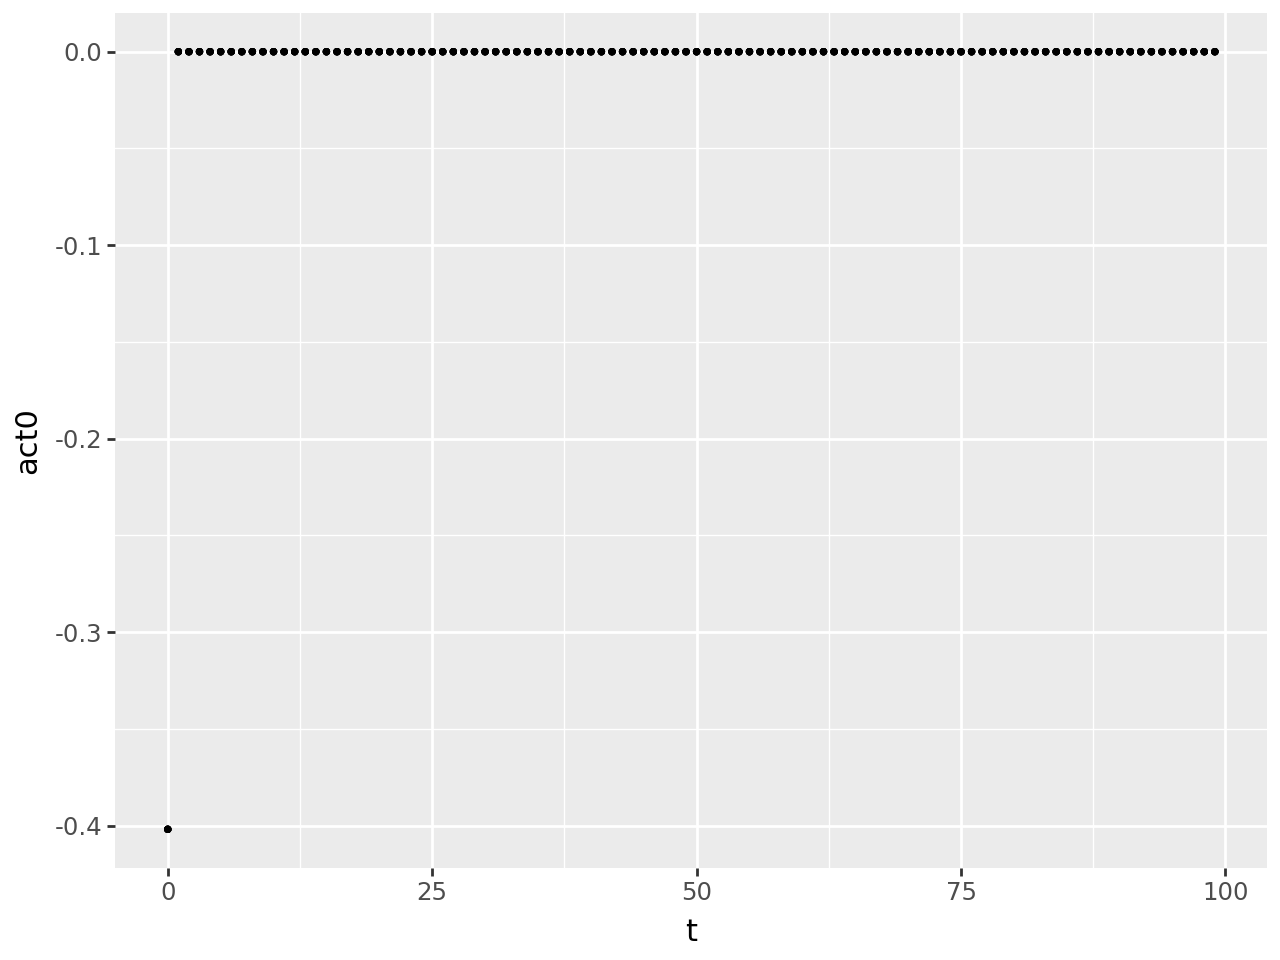

In [11]:
ggplot(gpp_df, aes("t", "act0")) + geom_point(shape=".")

In [12]:
gpp_policy_df = gpp_policy_plot_2fish(
gpp, env, path_and_filename = os.path.join(DATAPATH,f"gpp{ITERATIONS}-pol.png")
)
gpp_policy_df.to_csv(os.path.join(DATAPATH,f"gpp{ITERATIONS}_policy_data.csv.xz"))

## data wrangling
msy_max_t = values_at_max_t(msy_df, group="rep")
ppo_max_t = values_at_max_t(ppo_df, group="rep")
gpp_max_t = values_at_max_t(gpp_df, group="rep")
esc_max_t = values_at_max_t(esc_df, group="rep")
msy_max_t['strategy']='CMort'
esc_max_t['strategy']='CEsc'
ppo_max_t['strategy']='PPO'
gpp_max_t['strategy']='PPO+GP'
tot_max_t = pd.concat([msy_max_t, esc_max_t, ppo_max_t, gpp_max_t])

tot_max_t.to_csv(os.path.join(DATAPATH,f"comparison_{ITERATIONS}.csv.xz"))
print("Done with data generation, finishing up on plots...")

NameError: name 'gpp_policy_plot_2fish' is not defined